In [2]:
import torch
from torch import nn

import matplotlib.pyplot as plt
from intervals import Interval
import numpy as np
from tqdm.notebook import tqdm
import random

import env
import gdbp_falsification
import Model

from importlib import reload
reload(env)
reload(gdbp_falsification)
reload(Model)

from env import Osillator, OsillatorGpu
from gdbp_falsification import mdist_to_boundary, init_falsify_gdbp_search, DQN, SwitchController
from Model import Actor

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
model_1 = Actor(state_size=2, action_size=1, seed=0, fc1_units=25, fc2_units=None).to(device)
model_1.load_state_dict(torch.load("./models/actor_2800.pth", map_location=torch.device('cpu')))
model_1.eval()

Actor(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=1, bias=True)
)

In [34]:
state_histories = init_falsify_gdbp_search(model_1, return_seq=True)

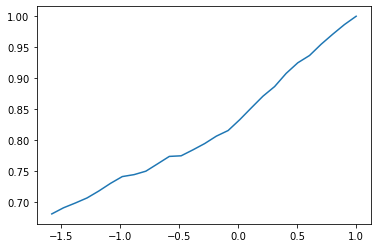

In [35]:
x1 = [h[0][0] for h in state_histories]
x2 = [h[0][1] for h in state_histories]
plt.plot(x1, x2)

4


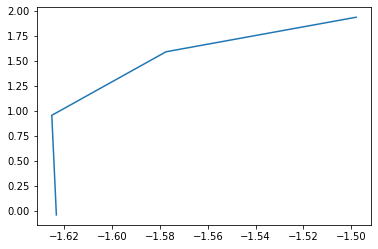

In [124]:
x1 = [s[0] for s in state_histories[-1]]
x2 = [s[1] for s in state_histories[-1]]
print(len(x1))
plt.plot(x1, x2)

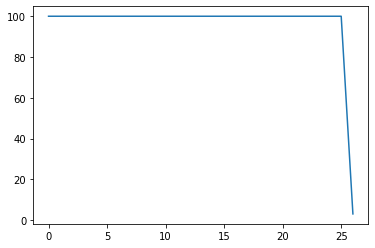

In [36]:
plt.plot([h.shape[0] for h in state_histories])

### Multiple controllers experiment

In [39]:
model_2 = Actor(state_size=2, action_size=1, seed=0, fc1_units=25).to(device)
model_2.load_state_dict(torch.load("./0731actors/actor_2400.pth", map_location=device))
model_2.eval()

Actor(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=1, bias=True)
)

In [78]:
switch_model = DQN(2, 2).to(device)
switch_model.load_state_dict(torch.load('switcher.pth', map_location=device))
switch_model.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [84]:
env = OsillatorGpu()
state = env.state
action = switch_model.softact(state)
control_action_1 = model_1(state)
control_action_2 = model_2(state)
switch_action = action[0] * control_action_1 + action[1] * control_action_2
print(switch_action)

tensor([0.7073], grad_fn=<AddBackward0>)


In [90]:
sc = SwitchController(base_model_paths=["./models/actor_2800.pth", "./0731actors/actor_2400.pth"],
                      switch_path="switcher.pth")

In [106]:
init_state = [random.uniform(-2, 2), random.uniform(-2, 2)]
state_histories = init_falsify_gdbp_search(model=sc, init_state=init_state, return_seq=True)

[-1.0056497  -0.21336155] [-1.6288519  -0.29090443]


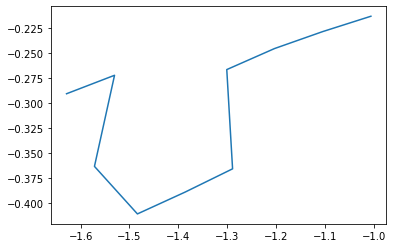

In [107]:
print(state_histories[0][0], state_histories[-1][0])
x1 = [h[0][0] for h in state_histories]
x2 = [h[0][1] for h in state_histories]
plt.plot(x1, x2)

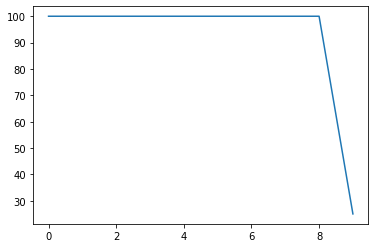

In [108]:
plt.plot([h.shape[0] for h in state_histories])

[-0.06835281, -0.08166894, -0.061554417, -0.07294881, -0.07447164, -0.075484835, -0.07753327, -0.07000029, -0.07704526, -1.5954651]
[-0.01965409, -0.058630623, 0.011859097, 0.010302875, 0.03293225, 0.06814883, 0.045527857, 0.045622, -0.026528567, 1.9475883]


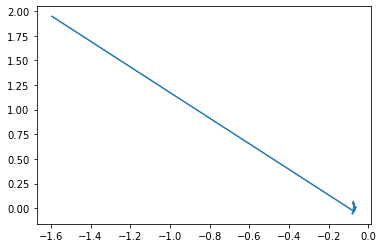

In [118]:
x1 = [h[-1][0] for h in state_histories]
x2 = [h[-1][1] for h in state_histories]
print(x1)
print(x2)
line = plt.plot(x1, x2)[0]

In [119]:
success_cnt = 0
for _ in range(100):
    init_state = [random.uniform(-2, 2), random.uniform(-2, 2)]
    state_histories = init_falsify_gdbp_search(model=sc, init_state=init_state, return_seq=True)
    if len(state_histories) < 100 and state_histories[-1][0][0] > -2 and state_histories[-1][0][0] < 2 and \
        state_histories[-1][0][1] > -2 and state_histories[-1][0][1] < 2:
        success_cnt += 1

In [120]:
print(success_cntess_cnt)

62


In [121]:
success_cnt_single = 0
for _ in range(100):
    init_state = [random.uniform(-2, 2), random.uniform(-2, 2)]
    state_histories = init_falsify_gdbp_search(model=model_1, init_state=init_state, return_seq=True)
    if len(state_histories) < 100 and state_histories[-1][0][0] > -2 and state_histories[-1][0][0] < 2 and \
        state_histories[-1][0][1] > -2 and state_histories[-1][0][1] < 2:
        success_cnt_single += 1

In [122]:
print(success_cnt_single)

92
